# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
## import libraries
from google.colab import drive
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn import model_selection
from keras import layers
from sklearn.model_selection import train_test_split

##Import CNN related libraries
import keras
from keras import callbacks, optimizers
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2, Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


Go into the model folder directly

In [ ]:
cd '/content/gdrive/MyDrive/Colab Notebooks/ML2'

/content/gdrive/MyDrive/Colab Notebooks/ML2


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [ ]:
#Specify the path of data
directory_path = 'train_val/'
directory_files = os.listdir(directory_path)

#Read data into a dataframe, with columns age, gender and filename
df = pd.DataFrame(columns = ['age','gender','filename'])

for i in range(len(directory_files)):
  df.loc[i] = int(directory_files[i].split("_")[0]),int(directory_files[i].split("_")[1]),directory_files[i]


In [ ]:
#Have a brief view of the dataframe
df.head()

,age,gender,filename
0,40,0,40_0_3_20170119183403621.jpg.chip.jpg
1,75,0,75_0_0_20170117174511134.jpg.chip.jpg
2,18,1,18_1_0_20170109213011914.jpg.chip.jpg
3,70,1,70_1_3_20170116224931319.jpg.chip.jpg
4,26,1,26_1_1_20170116232602440.jpg.chip.jpg


In [ ]:
df['gender'].value_counts()

0    2584
1    2416
Name: gender, dtype: int64

There is no imbalance issues with the genders, we can proceed.

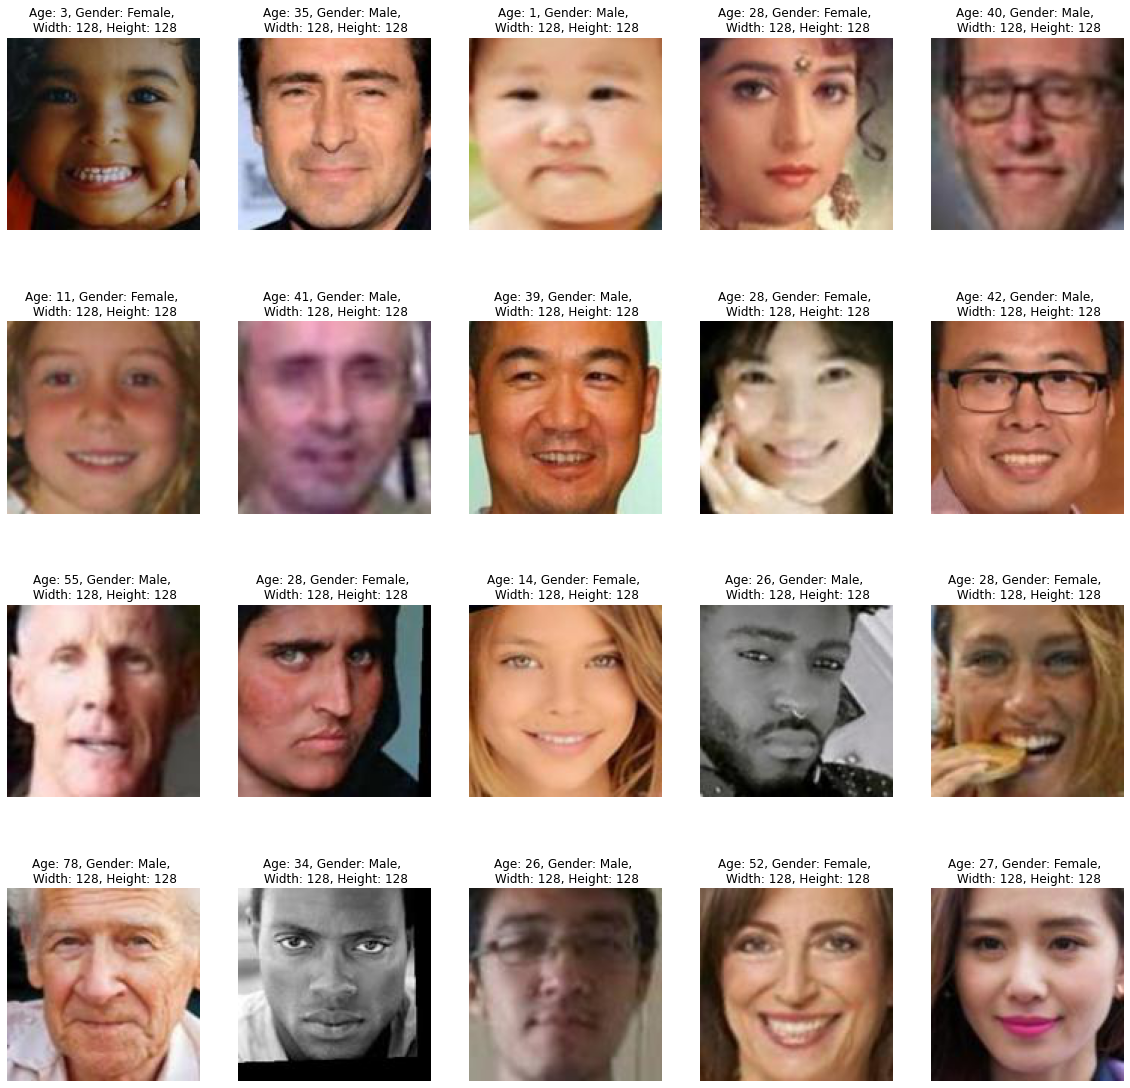

In [ ]:
#take a sample of 20 images
df_sample = df.sample(n=20, replace=False)

#output age, gender and image size along with the corresponding image
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i in range(len(df_sample)):
    age = df_sample.iloc[i]['age']
    if df_sample.iloc[i]['gender'] == 0:
      gender = 'Male'
    else:
      gender = 'Female'
    with Image.open('train_val/'+ df_sample.iloc[i]['filename']) as img:
      width, height = img.size

    path = "train_val/" + df_sample.iloc[i]['filename']
    image = imread(path)
    axes[i//5, i%5].imshow(image)
    axes[i//5, i%5].set_title(f'Age: {age}, Gender: {gender}, \n Width: {width}, Height: {height}')
    axes[i//5, i%5].axis('off')


plt.show()


As we can see, the sizes of images are all 128x128, and the ages and genders are all as expected.

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#first we need to change the datatype of 'gender' and 'age' to integers

df['gender'] = df['gender'].astype(int)

df['age']=df['age'].astype(int)

In [ ]:
#now we split the data into training and validation sets,
#in the ratio of 80% training to 20% validation
df2 = df.copy()
gender_df = df2.pop('gender').to_frame()
full_data = df
train, val, y_train, y_test = sklearn.model_selection.train_test_split(
        full_data, gender_df,stratify=gender_df, test_size=0.2)



## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
image_size = (128, 128) # set the input image size
batch_size = 32 # 32 images in each batch

#now we perform rescaling and data augmentation on the traiing data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='train_val/',
    x_col='filename',
    y_col=['age', 'gender'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output' #class_mode set to multi_output since we have a different output types for age and gender
)

#rescale the validation data
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe= val,
    directory='train_val/',
    x_col='filename',
    y_col=['age', 'gender'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output'
)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 126, 126, 8)  224         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 63, 63, 8)   0           ['conv2d_22[0][0]']              
 )                                                                                                
                                                                                            

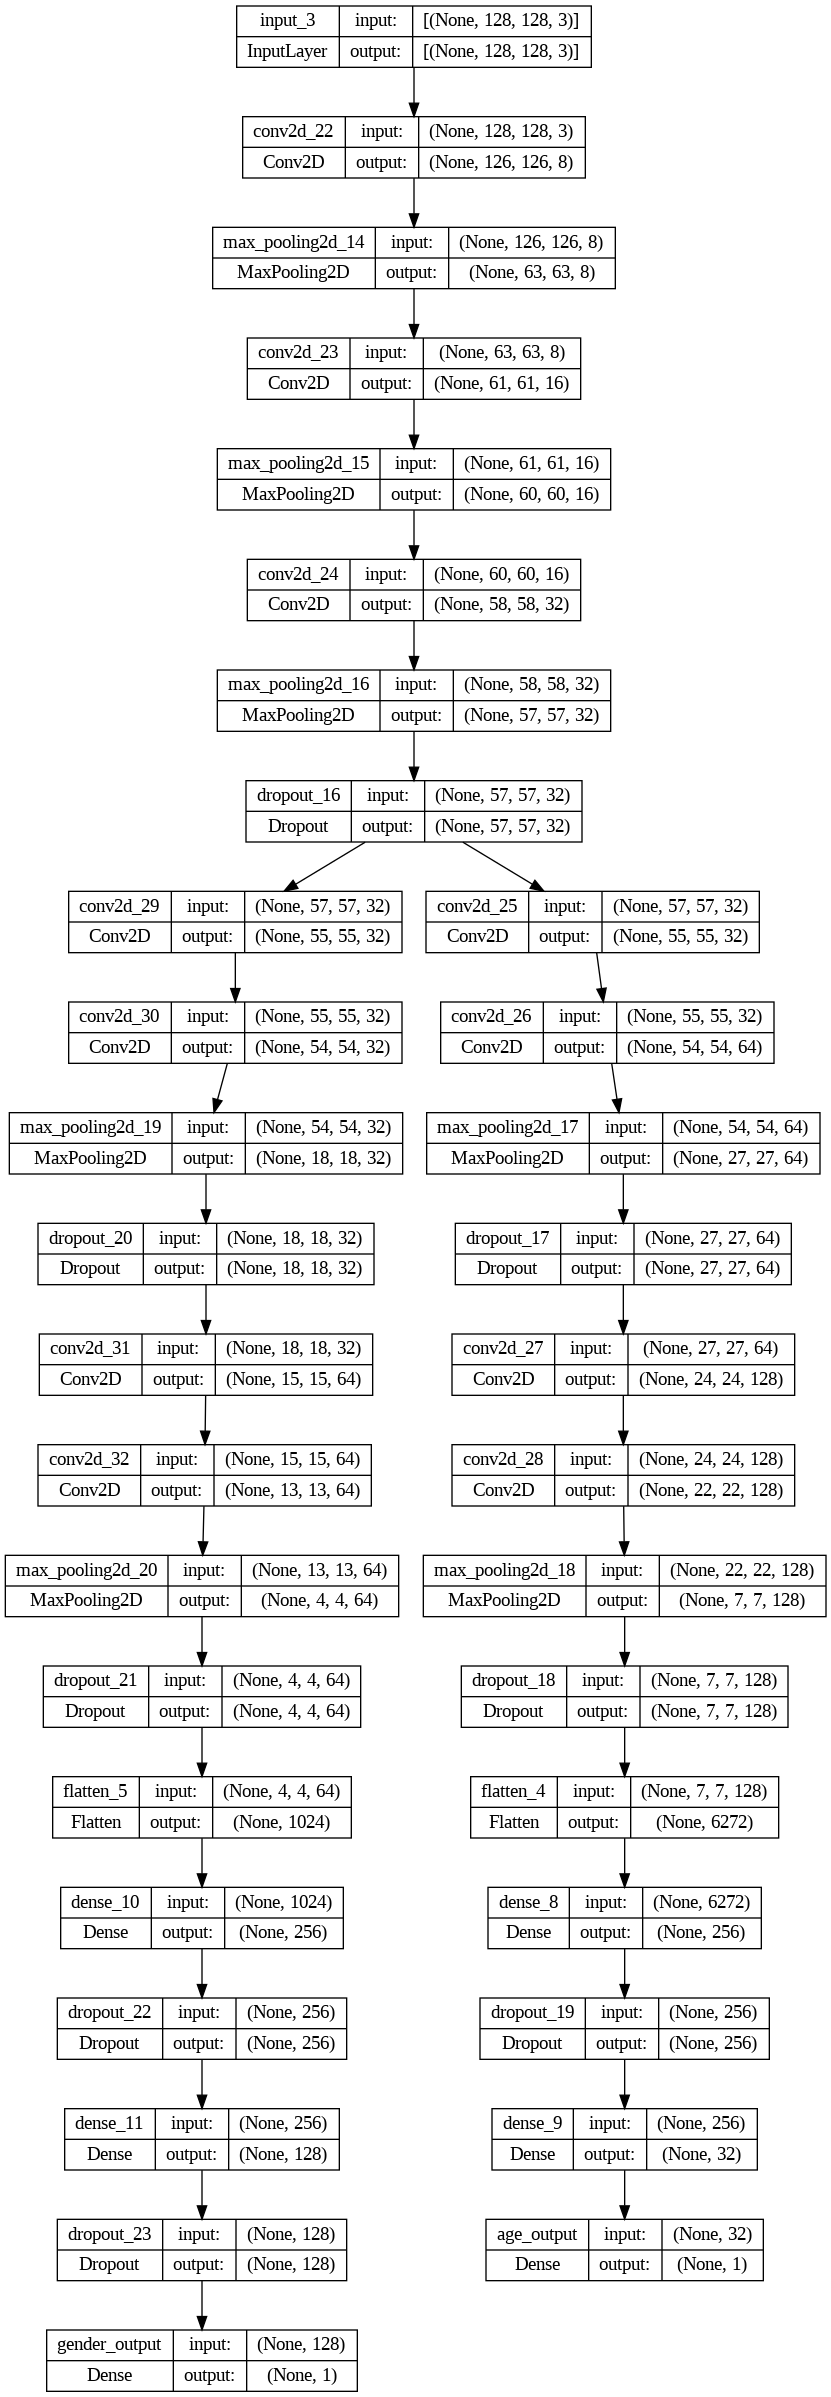

In [ ]:
#
# Add your code here
#
from keras.models import Sequential
from keras import Model, Input
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout

#set input shape
input_shape = (128,128,3)

inputs = Input(input_shape)

#create a base model, in the form of 3 conv-pool layers
base_model = Conv2D(8, (3,3), activation='relu')(inputs)
base_model = MaxPooling2D((2, 2))(base_model)
base_model = Conv2D(16, (3,3), activation='relu')(base_model)
base_model = MaxPooling2D((2,2),strides = 1)(base_model)
base_model = Conv2D(32, (3,3), activation='relu')(base_model)
base_model = MaxPooling2D((2,2),strides = 1)(base_model)
base_model = Dropout(0.2)(base_model)

#create a model for age estimation on top of the base model
age_model = Conv2D(32, (3,3), activation='relu')(base_model)
age_model = Conv2D(64, (2,2), activation='relu')(age_model)
age_model = MaxPooling2D((2, 2))(age_model)
age_model = Dropout(0.1)(age_model)
age_model = Conv2D(128, (4,4), activation='relu')(age_model)
age_model = Conv2D(128, (3,3), activation='relu')(age_model)
age_model = MaxPooling2D((3, 3))(age_model)
age_model = Dropout(0.1)(age_model)
age_model = Flatten()(age_model)
age_model = Dense(256,activation = 'relu')(age_model)
age_model = Dropout(0.2)(age_model)
age_model = Dense(32,activation = 'relu')(age_model)
age_model = Dense(1,activation = 'relu',name = 'age_output')(age_model)

#create a model for gender classification on top of the base model
gender_model = Conv2D(32, (3,3), activation='relu')(base_model)
gender_model = Conv2D(32, (2,2), activation='relu')(gender_model)
gender_model = MaxPooling2D((3, 3))(gender_model)
gender_model = Dropout(0.1)(gender_model)
gender_model = Conv2D(64, (4,4), activation='relu')(gender_model)
gender_model = Conv2D(64, (3,3), activation='relu')(gender_model)
gender_model = MaxPooling2D((3, 3))(gender_model)
gender_model = Dropout(0.1)(gender_model)
gender_model = Flatten()(gender_model)
gender_model = Dense(256,activation = 'relu')(gender_model)
gender_model = Dropout(0.2)(gender_model)
gender_model = Dense(128,activation = 'relu')(gender_model)
gender_model = Dropout(0.2)(gender_model)
gender_model= Dense(1,activation = 'sigmoid',name = 'gender_output')(gender_model)

#comebine the two models together into a multi-output model
modelA = Model(inputs=inputs, outputs=[age_model, gender_model])


modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [ ]:
#
# Add your code here
#

from keras import callbacks, optimizers

#create early stopping
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 10,
                                        restore_best_weights = True)

#compile the model, with appropriate metrics to assess performance
batch_size = 32

modelA.compile(loss={'age_output':'mse','gender_output':'binary_crossentropy'},
            optimizer= optimizers.Adam(learning_rate = 0.001),
            metrics={'age_output':'mae','gender_output':'accuracy'})


#train the model
n_train = len(train)
n_val = len(val)

history = modelA.fit_generator(train_generator,
                     steps_per_epoch=n_train// batch_size,
                     validation_data=val_generator,
                     validation_steps=n_val// batch_size,
                     epochs = 40,
                     shuffle = True,
                     callbacks = [earlystopping])


#save the model
modelA.save("age_gender_A.h5")

<ipython-input-33-2d4c665dce2e>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelA.fit_generator(train_generator,


Epoch 1/40
125/125 [==============================] - 254s 2s/step - loss: 511.9449 - age_output_loss: 511.2504 - gender_output_loss: 0.6945 - age_output_mae: 17.4036 - gender_output_accuracy: 0.5040 - val_loss: 472.2752 - val_age_output_loss: 471.5831 - val_gender_output_loss: 0.6922 - val_age_output_mae: 16.0136 - val_gender_output_accuracy: 0.5192
Epoch 2/40
125/125 [==============================] - 21s 166ms/step - loss: 419.0349 - age_output_loss: 418.3424 - gender_output_loss: 0.6924 - age_output_mae: 15.7231 - gender_output_accuracy: 0.5175 - val_loss: 408.0718 - val_age_output_loss: 407.3804 - val_gender_output_loss: 0.6914 - val_age_output_mae: 14.5318 - val_gender_output_accuracy: 0.5171
Epoch 3/40
125/125 [==============================] - 21s 167ms/step - loss: 417.4312 - age_output_loss: 416.7419 - gender_output_loss: 0.6893 - age_output_mae: 15.7585 - gender_output_accuracy: 0.5370 - val_loss: 361.6258 - val_age_output_loss: 361.0061 - val_gender_output_loss: 0.6198 - va

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


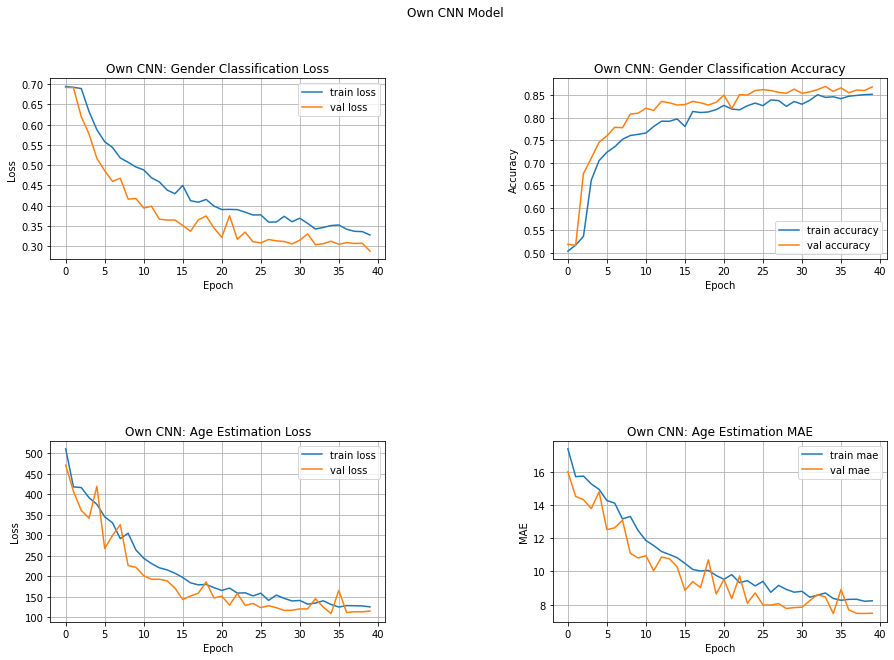

In [ ]:
#
# Add your code here
#
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

fig.add_subplot(2,2,1)
fig.suptitle('Own CNN Model')

#gender classification loss plot
plt.plot(history.history['gender_output_loss'], label = 'train loss')
plt.plot(history.history['val_gender_output_loss'], label = 'val loss')
plt.title('Own CNN: Gender Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')

#gender classification accuracy plot
fig.add_subplot(2,2,2)
plt.plot(history.history['gender_output_accuracy'], label = 'train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label = 'val accuracy')
plt.title('Own CNN: Gender Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='lower right')

#age estimation loss plot
fig.add_subplot(2,2,3)
plt.plot(history.history['age_output_loss'], label = 'train loss')
plt.plot(history.history['val_age_output_loss'], label = 'val loss')
plt.title('Own CNN: Age Estimation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')

#age estimation mae plot
fig.add_subplot(2,2,4)
plt.plot(history.history['age_output_mae'], label = 'train mae')
plt.plot(history.history['val_age_output_mae'], label = 'val mae')
plt.title('Own CNN: Age Estimation MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend( loc='upper right')



## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


## VGG16 Model

58889256/58889256 [==============================] - 0s 0us/step
Model: "VGG16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                             

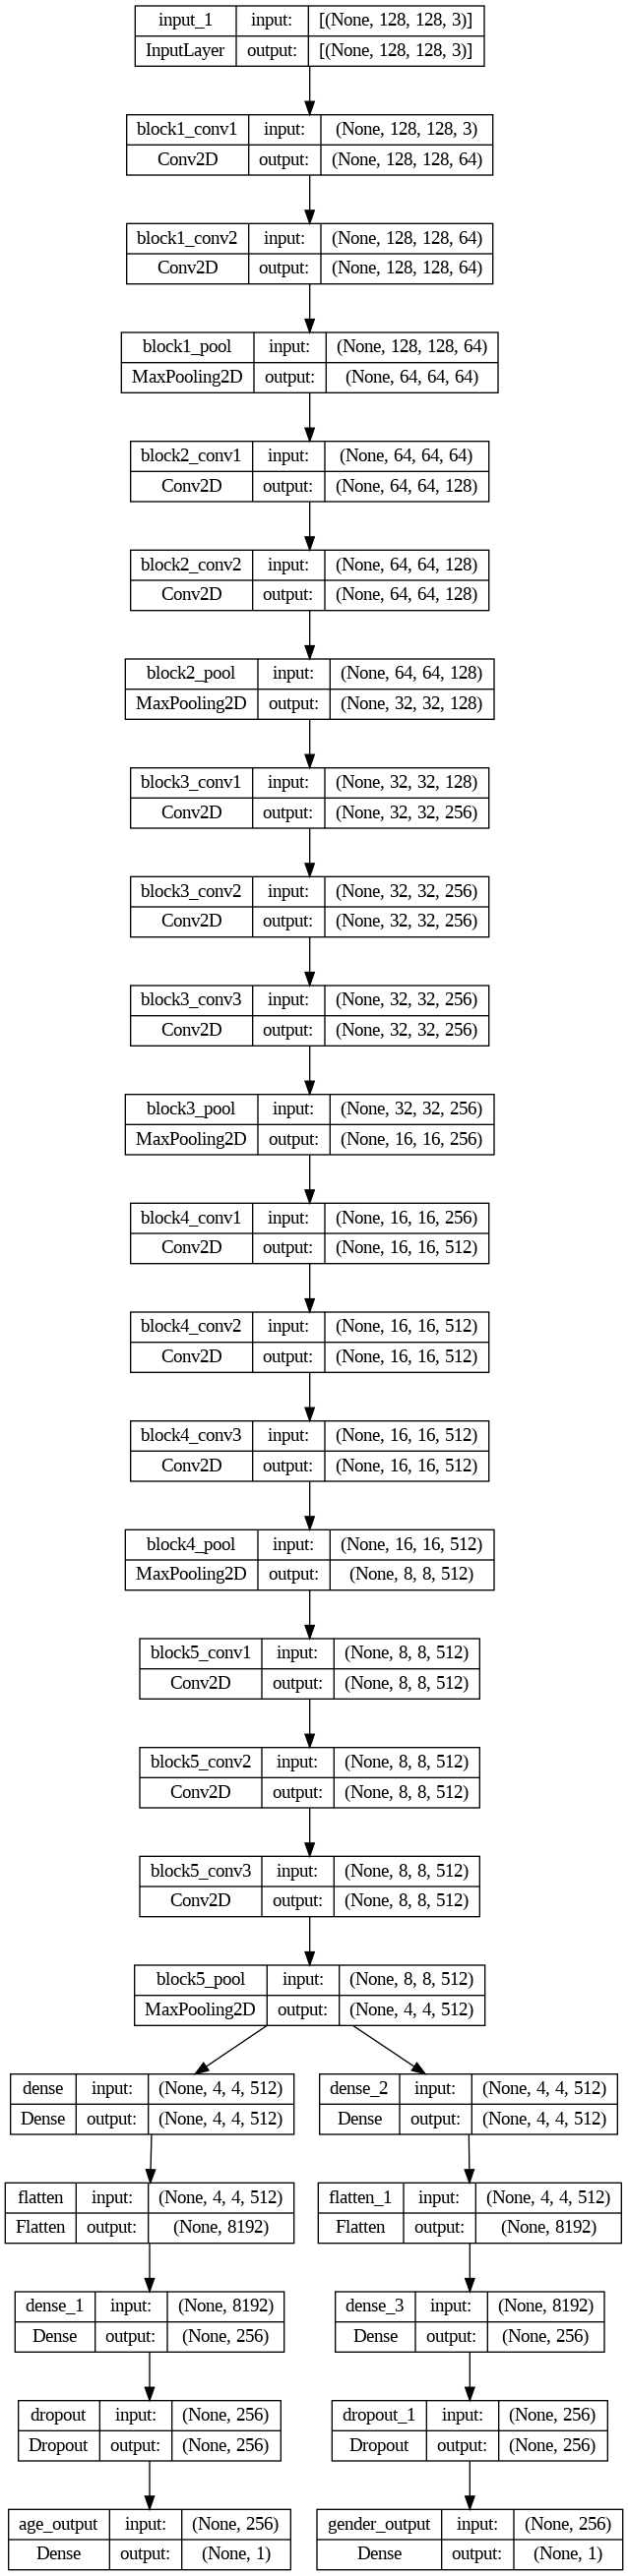

In [ ]:
#
# Add your code here
#
import keras
from keras.applications import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# load the pre-trained VGG16 model without the top layer (the FC layer)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers to prevent them from being updated during training
for layer in vgg16_model.layers:
    layer.trainable = False

# build a classifier to put on top of the convolutional model
x = vgg16_model.output

a = Dense(512, activation='relu')(x)
a = Flatten()(a)
a = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(a)
a = Dropout(0.5)(a)

g = Dense(512, activation='relu')(x)
g = Flatten()(g)
g = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(g)
g = Dropout(0.5)(g)
# x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
# x = Dropout(0.8)(x)

# final fully connected output layer for classification and regression
age_output = Dense(1, activation='relu', name='age_output')(a)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(g)


# Create a multi-output model
modelB = Model(inputs=vgg16_model.input, outputs=[age_output, gender_output], name ="VGG16")

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True) # visualize the CNN artitecture

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
#
# Add your code here
#

#Set the hyperparameters
batch_size = 32

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 10, restore_best_weights = True)
#loss_weights = {'age_output': 0.6, 'gender_output': 0.4}
n_train = len(train)
n_val = len(val)


# Compile the model with appropriate loss functions for each output
print("[INFO] compiling model...")
modelB.compile(optimizer= optimizers.Adam(learning_rate = 0.0001),
               loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

# Fine-tune the model for a fixed number of epochs
print("[INFO] training head...")
train_generator.reset()
val_generator.reset()

history = modelB.fit(train_generator,
                     steps_per_epoch= n_train// batch_size,
                     validation_data= val_generator,
                     validation_steps= n_val// batch_size,
                     epochs = 100,
                     shuffle = True,
                     callbacks = [earlystopping])


modelB.save("age_gender_B.h5")


[INFO] compiling model...
[INFO] training head...
Epoch 1/100
125/125 [==============================] - 82s 172ms/step - loss: 427.7729 - age_output_loss: 427.0680 - gender_output_loss: 0.6192 - age_output_mae: 15.8360 - gender_output_accuracy: 0.6530 - val_loss: 316.9826 - val_age_output_loss: 316.4281 - val_gender_output_loss: 0.4780 - val_age_output_mae: 13.8223 - val_gender_output_accuracy: 0.7863
Epoch 2/100
125/125 [==============================] - 21s 168ms/step - loss: 258.3197 - age_output_loss: 257.7453 - gender_output_loss: 0.5017 - age_output_mae: 12.4284 - gender_output_accuracy: 0.7555 - val_loss: 236.9596 - val_age_output_loss: 236.4730 - val_gender_output_loss: 0.4163 - val_age_output_mae: 11.9173 - val_gender_output_accuracy: 0.8115
Epoch 3/100
125/125 [==============================] - 21s 166ms/step - loss: 220.1983 - age_output_loss: 219.6702 - gender_output_loss: 0.4589 - age_output_mae: 11.5614 - gender_output_accuracy: 0.7825 - val_loss: 208.5091 - val_age_outp

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

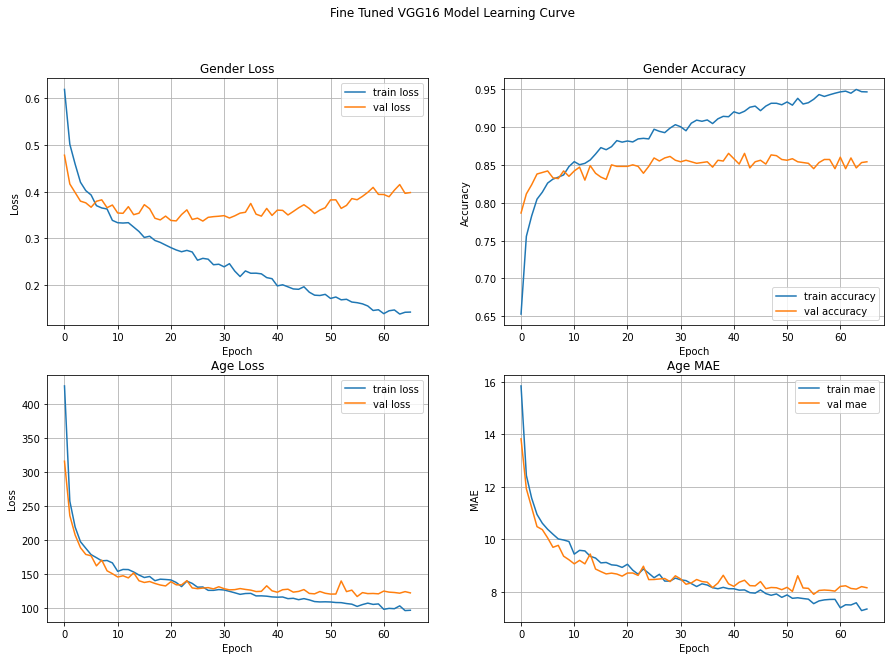

In [ ]:

fig = plt.figure(figsize=(15,10))
# plot the loss of the gender classification over the training and validation set

fig.add_subplot(2,2,1)

fig.suptitle('Fine Tuned VGG16 Model Learning Curve')
plt.plot(history.history['gender_output_loss'], label = 'train loss')
plt.plot(history.history['val_gender_output_loss'], label = 'val loss')
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('gender_loss.png')
# plt.show()

# plot the accuracy of the gender classification over the training and validation set
fig.add_subplot(2,2,2)
plt.plot(history.history['gender_output_accuracy'], label = 'train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label = 'val accuracy')
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('gender_accuracy.png')
# plt.show()

# plot the loss of the age estimation over the training and validation set
fig.add_subplot(2,2,3)
plt.plot(history.history['age_output_loss'], label = 'train loss')
plt.plot(history.history['val_age_output_loss'], label = 'val loss')
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('age_loss.png')
# plt.show()

# plot the MAE of the age estimation over the training and validation set
fig.add_subplot(2,2,4)
plt.plot(history.history['age_output_mae'], label = 'train mae')
plt.plot(history.history['val_age_output_mae'], label = 'val mae')
plt.title('Age MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend( loc='upper right')
plt.savefig('age_mae.png')
# plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#
